In [161]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

from pathlib import Path

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
%load_ext autoreload
%autoreload 2
from utils import *

# scperturb package
sys.path.insert(1, '../../package/src/')
from scperturb import *

from pathlib import Path
figure_path = Path('../../figures/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
DATADIR = Path('/data/gpfs-1/users/peidlis_c/work/data/perturbation_resource_paper')

In [163]:
# Load list of ATAC datasets available via scPerturb
df = pd.read_excel('../../metadata/scperturb_dataset_info.xlsx')  # supplemental table
df = df[df['Modality = Data type'].isin(['ATAC', 'ATAC + protein'])]
df.index = [a if pd.isna(b) else a+'_'+b for a, b in zip(df[df.columns[0]], df[df.columns[1]])]
datasets_atac = list(df.index)
print(datasets_atac)

['Liscovitch-BrauerSanjana2021_K562_1', 'Liscovitch-BrauerSanjana2021_K562_2', 'MimitouSmibert2021', 'PierceGreenleaf2021_K562', 'PierceGreenleaf2021_MCF7', 'PierceGreenleaf2021_GM12878']


In [164]:
features = ['ChromVar', 'LSI_embedding', 'gene_scores', 'peak_bc']

# MimitouSmibert2021

100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


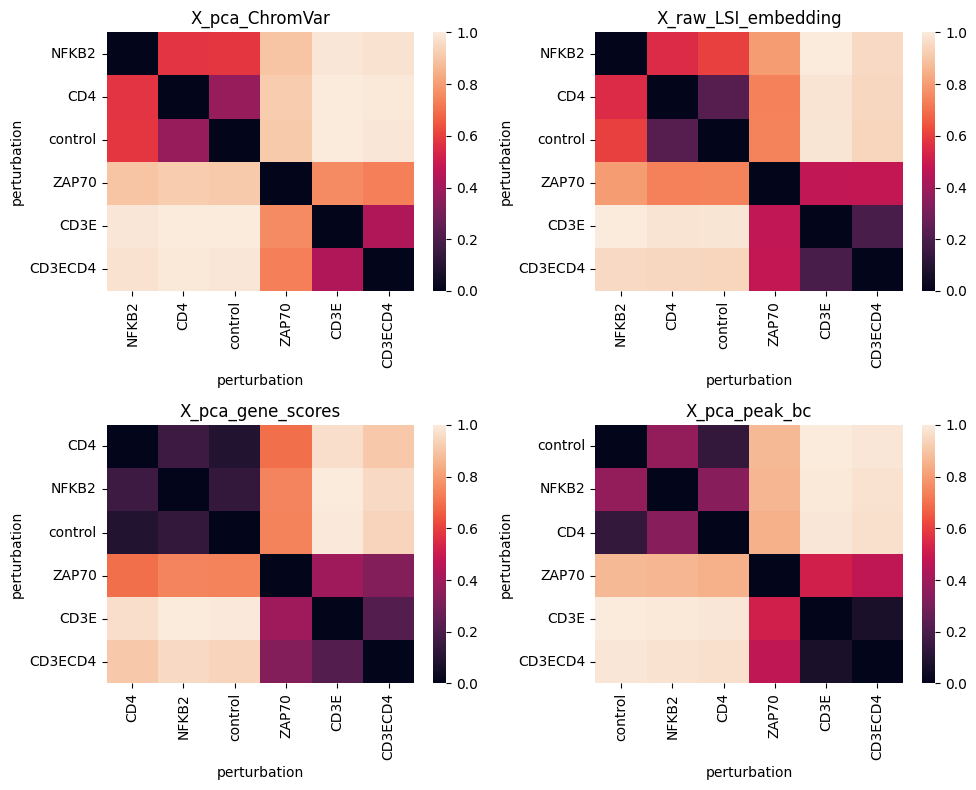

In [171]:
dataset = datasets_atac[2]

# compute e-distances in each feature
eds = {}
for feature in tqdm(features):
    adata = sc.read(DATADIR / f'tmp_ATAC_data_{dataset}_feature_{feature}.h5')
    adata = adata[~pd.isna(adata.obs.perturbation)].copy()
    obsm_key = [x for x in adata.obsm.keys() if feature in x][0]  # select feature embedding
    ed = edist(adata, obs_key='perturbation', obsm_key=obsm_key, flavor=1, verbose=False)
    eds[obsm_key] = cluster_matrix(ed.fillna(0), 'both')

# plot pairwise e-distances
fig, axss = pl.subplots(2,2,figsize=(10,8), dpi=100)
for obsm_key, ax in zip(eds.keys(), np.ravel(axss)):
    M = cluster_matrix(eds[obsm_key], 'both')
    M = np.log1p(M)
    M = M/np.max(np.max(M))
    sns.heatmap(M, robust=True, ax=ax)
    ax.set_title(obsm_key)
pl.tight_layout()
pl.show()

# PierceGreenleaf2021_K562

In [31]:
datasets_atac

['Liscovitch-BrauerSanjana2021_K562_1',
 'Liscovitch-BrauerSanjana2021_K562_2',
 'MimitouSmibert2021',
 'PierceGreenleaf2021_K562',
 'PierceGreenleaf2021_MCF7',
 'PierceGreenleaf2021_GM12878']

In [34]:
dataset = 'Liscovitch-BrauerSanjana2021_K562_1'#'PierceGreenleaf2021_K562'

In [35]:
# compute e-distances in each feature
eds = {}
for feature in tqdm(features):
    adata = sc.read(DATADIR / f'tmp_ATAC_data_{dataset}_feature_{feature}.h5')
    obsm_key = [x for x in adata.obsm.keys() if feature in x][0]  # select feature embedding
    ed = edist(adata, obs_key='perturbation', obsm_key=obsm_key, flavor=1, verbose=False)
    eds[obsm_key] = cluster_matrix(ed, 'both')

100%|██████████| 4/4 [00:05<00:00,  1.50s/it]


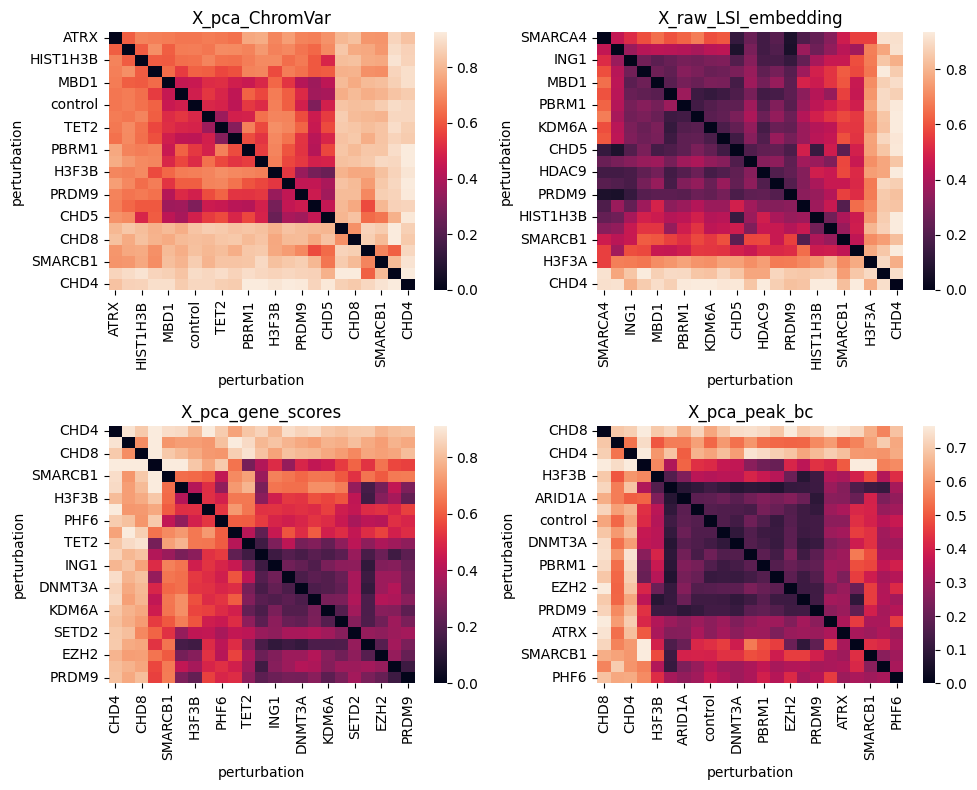

In [36]:
# plot pairwise e-distances
fig, axss = pl.subplots(2,2,figsize=(10,8), dpi=100)
for obsm_key, ax in zip(eds.keys(), np.ravel(axss)):
    M = cluster_matrix(eds[obsm_key], 'both')
    M = np.log1p(M)
    M = M/np.max(np.max(M))
    sns.heatmap(M, robust=True, ax=ax)
    ax.set_title(obsm_key)
pl.tight_layout()
pl.show()

## Best pair overlap (bad)

In [ ]:
# basically, I would like to know if the resulting "order of similarity" is the same.
# Like if A and B are the most similar in F1, are they also most similar in F2

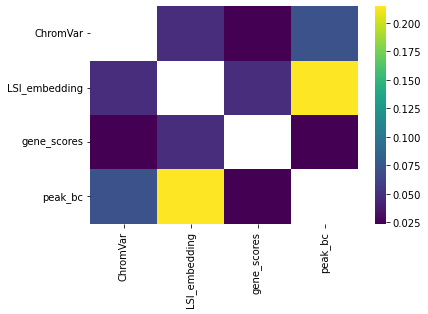

In [48]:
# overlap of most similar pairs
ms = []
for obsm_key, ax in zip(eds.keys(), np.ravel(axss)):
    M = cluster_matrix(eds[obsm_key], 'both')
    M = M/np.max(np.max(M))
    most_similar = pd.Series(np.argmin(M.values, axis=1), index=M.index)
    ms.append(most_similar)

MS = pd.concat(ms, axis=1)
MS.columns=features
P = pd.DataFrame(index=features, columns=features, dtype=float)
for f1 in features:
    for f2 in features:
        P.loc[f1, f2]=(np.sum(MS[f1]==MS[f2])) / len(MS) if f1!=f2 else None
sns.heatmap(P, robust=True, cmap='viridis');

## Frob norm (bad)

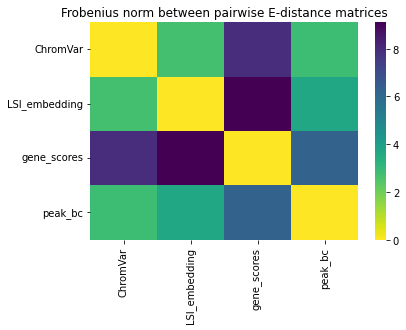

In [54]:
# Frobenius norm
ms = {}
for f, obsm_key, ax in zip(features, eds.keys(), np.ravel(axss)):
    M = eds[obsm_key]
    M = M/np.max(np.max(M))
    ms[f] = M
P = pd.DataFrame(index=features, columns=features, dtype=float)
for f1 in features:
    for f2 in features:
        P.loc[f1, f2]=np.linalg.norm(ms[f1]-ms[f2], ord='fro')
sns.heatmap(P, robust=True, cmap='viridis_r')
pl.title('Frobenius norm between pairwise E-distance matrices')
pl.show()

## Kendall tau (the way to go)

In [173]:
def pairwise_kendalltau(eds):
    from scipy.stats import kendalltau
    # ranked edist from control
    ms = {}
    for f, obsm_key, ax in zip(features, eds.keys(), np.ravel(axss)):
        ms[f] = eds[obsm_key].loc['control'].sort_values(ascending=False).index
    # get correlation coefficient and pvalue
    C = pd.DataFrame(index=features, columns=features, dtype=float)
    P = pd.DataFrame(index=features, columns=features, dtype=float)
    for f1 in features:
        for f2 in features:
            tau, pv = kendalltau(ms[f1], ms[f2])
            P.loc[f1, f2]=pv
            C.loc[f1, f2]=tau
    # plot
    sns.heatmap(cluster_matrix(C, 'both'), robust=True, cmap='viridis', annot=-np.log10(P))
    pl.title(r"Kendall's $\tau$ for E-distance to control " "\n"
             "(annot: -log10(pvalue))")
    pl.show()

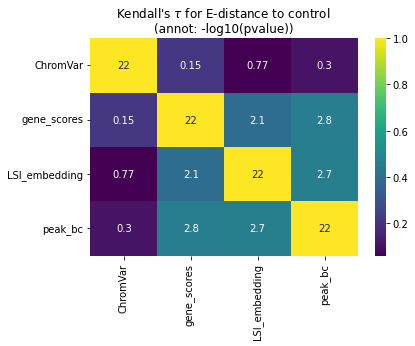

In [38]:
pairwise_kendalltau(eds)

# All

Liscovitch-BrauerSanjana2021_K562_1


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


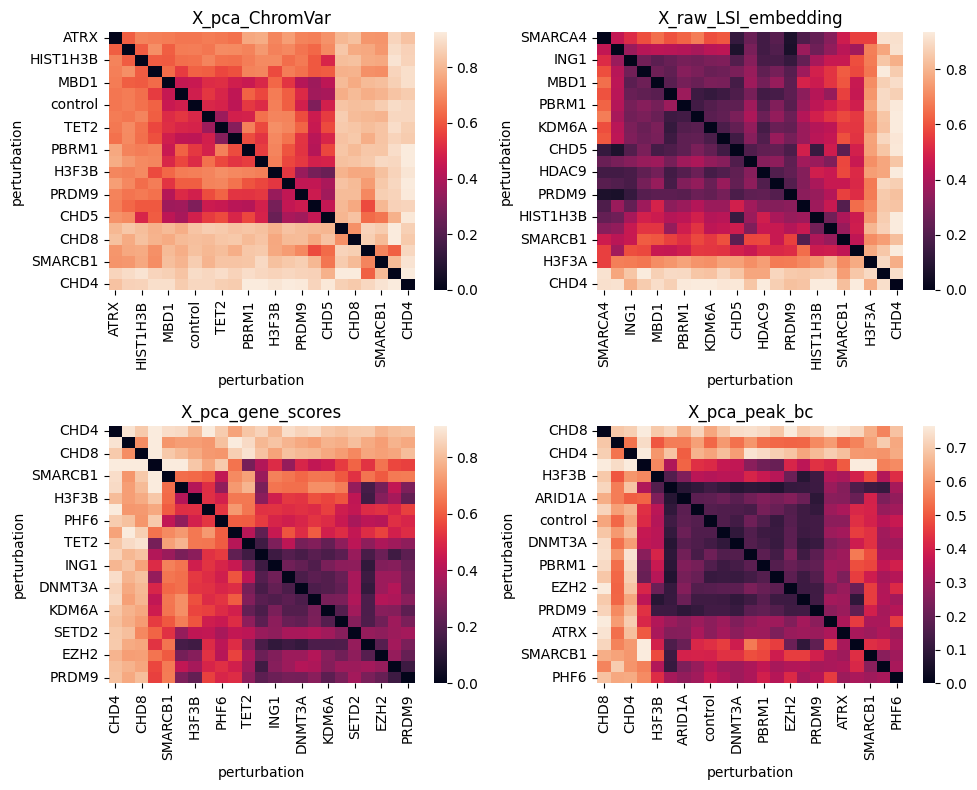

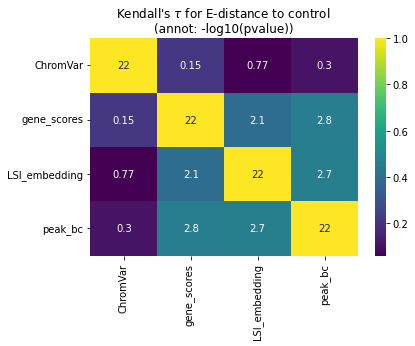

Liscovitch-BrauerSanjana2021_K562_2


100%|██████████| 4/4 [00:29<00:00,  7.47s/it]


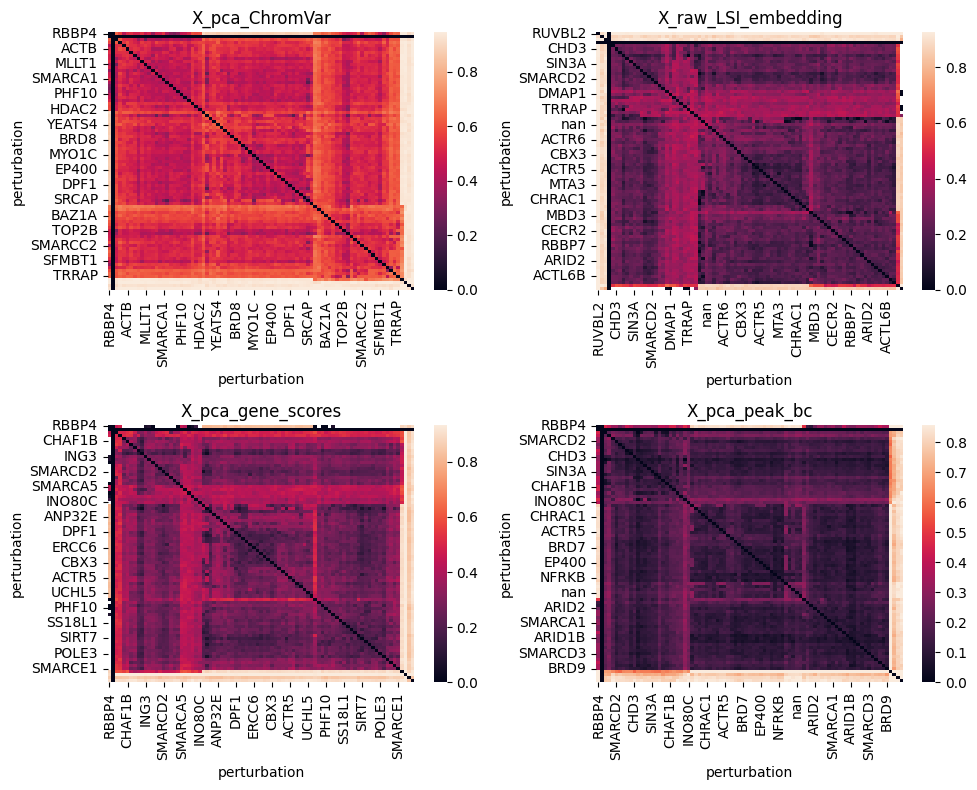

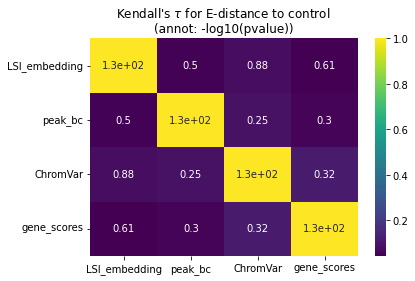

MimitouSmibert2021


100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


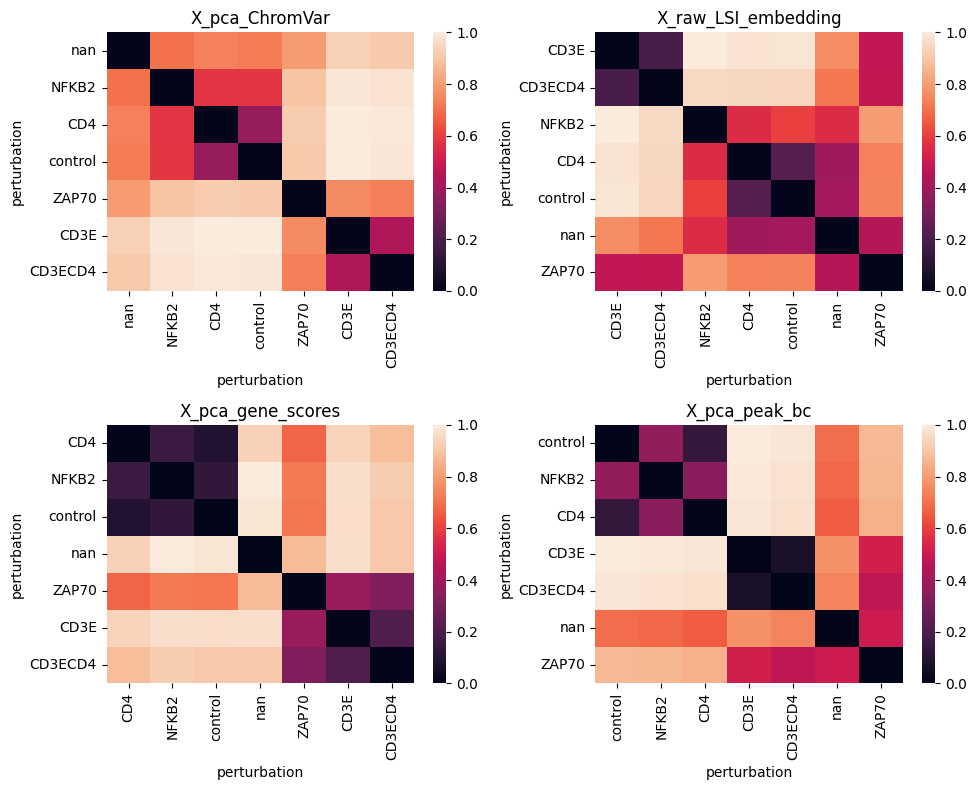

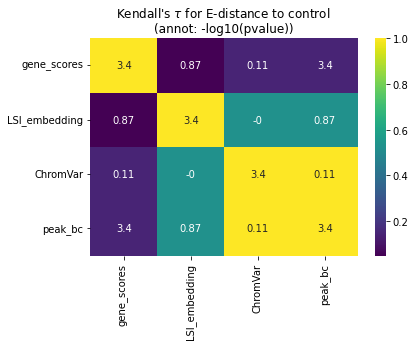

PierceGreenleaf2021_K562


100%|██████████| 4/4 [01:27<00:00, 21.88s/it]


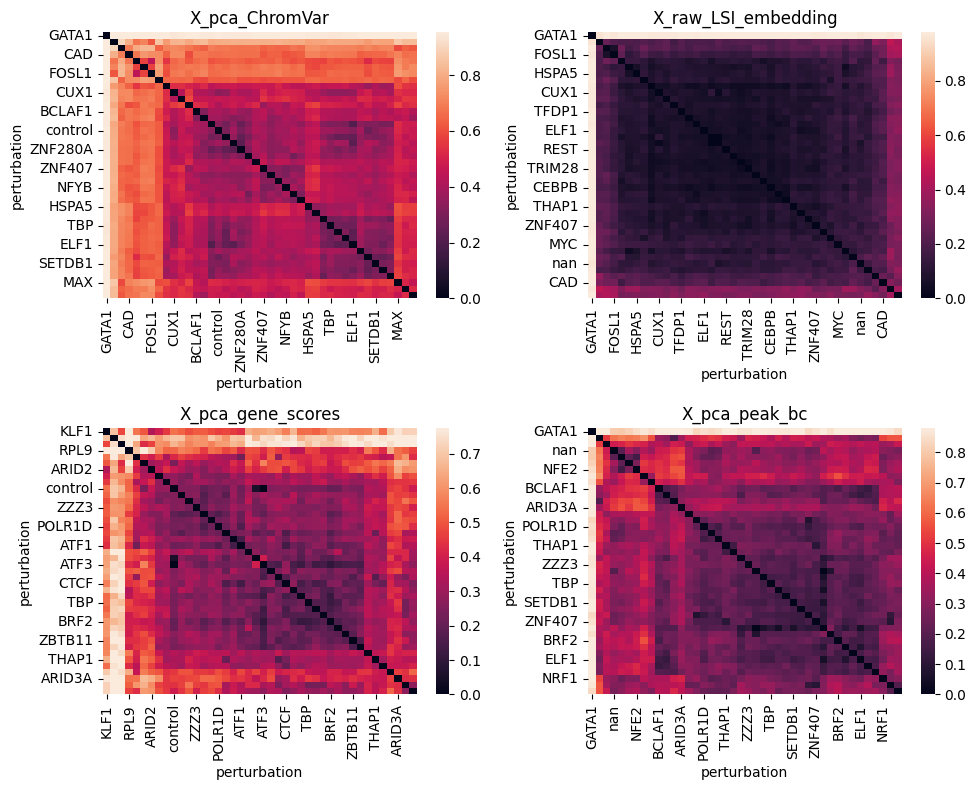

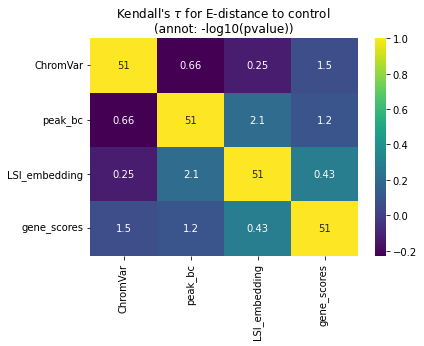

PierceGreenleaf2021_MCF7


100%|██████████| 4/4 [00:34<00:00,  8.53s/it]


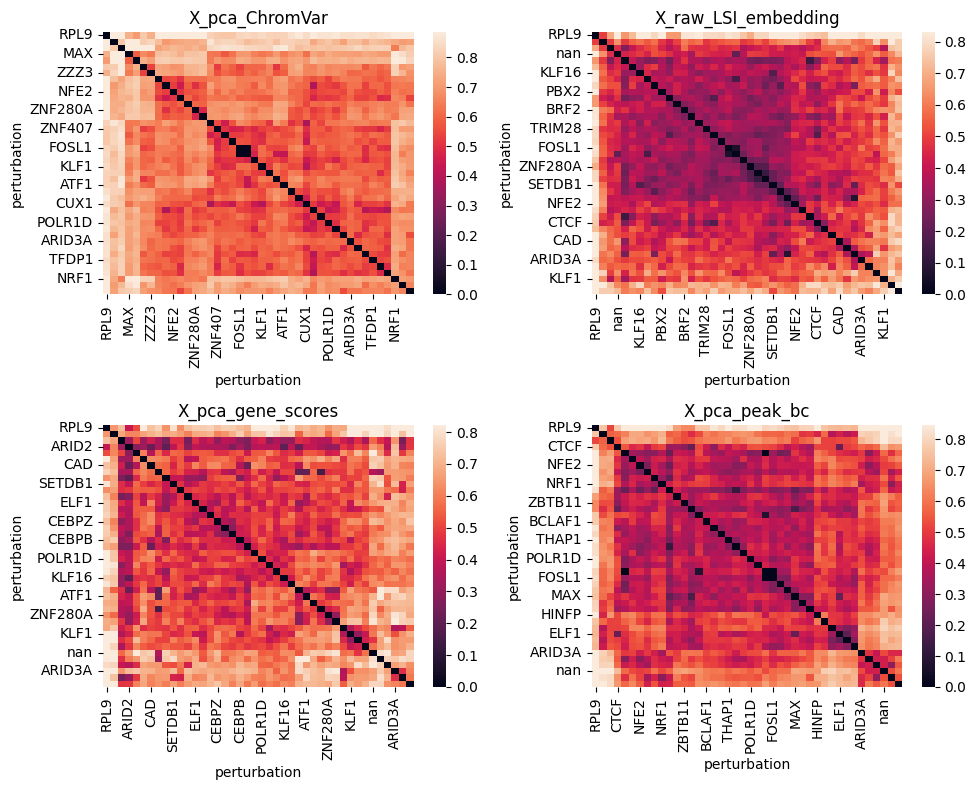

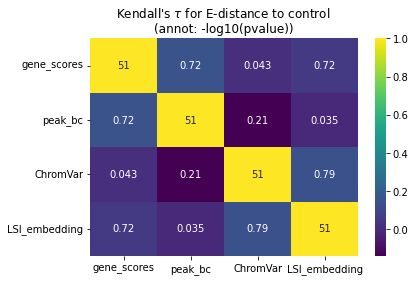

PierceGreenleaf2021_GM12878


100%|██████████| 4/4 [00:47<00:00, 11.85s/it]


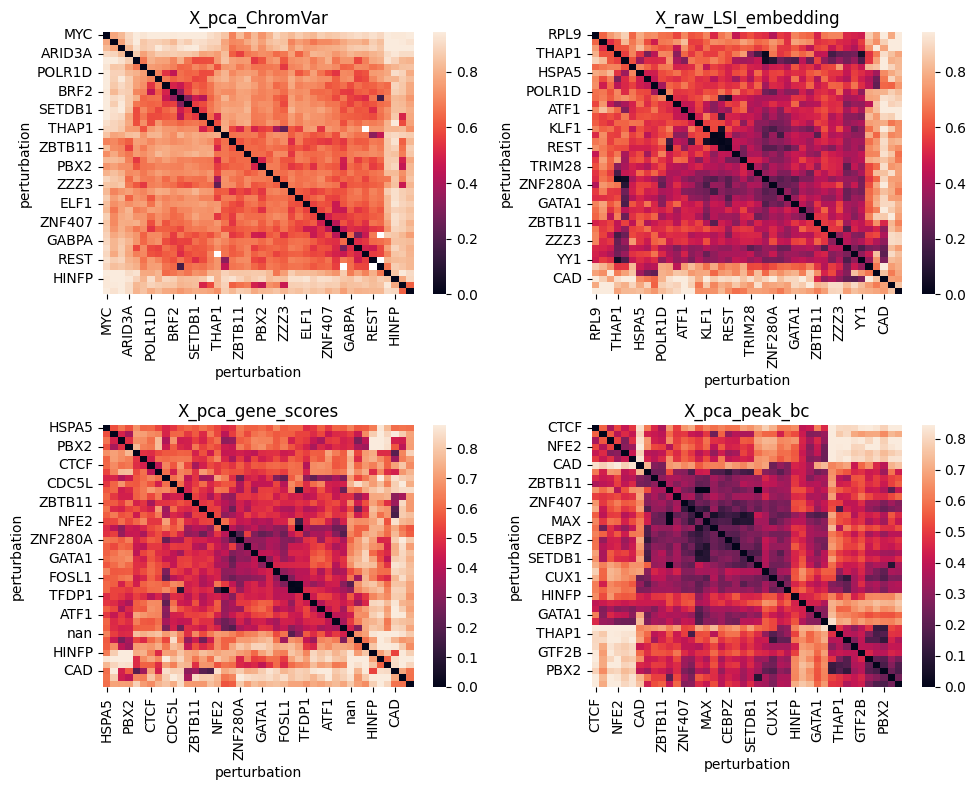

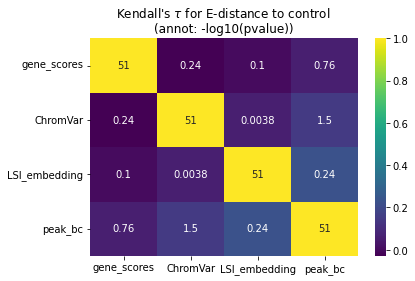

In [41]:
for dataset in datasets_atac:
    print(dataset)
    # compute e-distances in each feature
    eds = {}
    for feature in tqdm(features):
        adata = sc.read(DATADIR / f'tmp_ATAC_data_{dataset}_feature_{feature}.h5')
        obsm_key = [x for x in adata.obsm.keys() if feature in x][0]  # select feature embedding
        ed = edist(adata, obs_key='perturbation', obsm_key=obsm_key, flavor=1, verbose=False)
        eds[obsm_key] = cluster_matrix(ed.fillna(0), 'both')
    
    # plot pairwise e-distances
    fig, axss = pl.subplots(2,2,figsize=(10,8), dpi=100)
    for obsm_key, ax in zip(eds.keys(), np.ravel(axss)):
        M = cluster_matrix(eds[obsm_key], 'both')
        M = np.log1p(M)
        M = M/np.max(np.max(M))
        sns.heatmap(M, robust=True, ax=ax)
        ax.set_title(obsm_key)
    pl.tight_layout()
    pl.show()
    
    # kendall
    pairwise_kendalltau(eds)